In [1]:
import nbimporter
import numpy as np
from math import sqrt

from s04_01_general_Q import get_Q_T_H_d_t_i

# エアーコンディショナー
import s04_03_room_air_conditioner as rac
import s04_03_room_air_conditioner as rac_spec

# 温水床暖房
import s04_07_l_hot_water_floor_heating as hwfloor

# R410A におけるヒートポンプサイクルの理論効率の計算方法
from s04_08_a_heatpump_cycle import calc_e_ref_H_th

# 地域の区分と外気条件
from s11_01_external_condition import load_outdoor, get_Theta_ex, get_X_ex, calc_h_ex

## 第八節　ルームエアコンディショナー付温水床暖房 / Section 8  Hot Water Floor Heating with RAC

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5. 最大暖房出力 / Maximum heating output

$$\large
Q_{max,H,d,t} = Q_{max,H,floor,d,t} + Q_{max,H,RAC,d,t}
$$

$Q_{max,H,d,t}$：日付$d$の時刻$t$における1時間当たりの最大暖房出力(MJ/h) / Maximum heating output per hour at time $ t $ of date $ d $  
$Q_{max,H,floor,d,t}$：日付$d$の時刻$t$における1時間当たりの温水床暖房の最大暖房出力(MJ/h) / Maximum heating output of heated floor heating per hour at time $ t $ on date $ d $   
$Q_{max,H,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりのルームエアコンディショナーの最大暖房出力(MJ/h) / Maximum heating output of room air conditioner per hour at time $ t $ on date $ d $  

In [2]:
# 最大暖房出力 (1)
def calc_Q_max_H_d_t(region, Theta_SW_d_t, A_HCZ, r_Af):
    """最大暖房出力 (1)
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: flloat
    :return: 最大暖房出力 (MJ/h)
    :rtype: ndarray
    """
    # 温水床暖房の最大暖房出力 (MJ/h)
    Q_max_H_floor_d_t = calc_Q_max_H_floor_d_t(Theta_SW_d_t, A_HCZ, r_Af)

    # ルームエアコンディショナーの最大暖房出力 (MJ/h)
    Q_max_H_RAC_d_t = calc_Q_max_H_RAC_d_t(region, A_HCZ)

    # ルームエアコンディショナー付温水床暖房の最大暖房出力 (MJ/h)
    Q_max_H_d_t = Q_max_H_floor_d_t + Q_max_H_RAC_d_t

    return Q_max_H_d_t

In [3]:
# 温水床暖房の最大暖房出力
def calc_Q_max_H_floor_d_t(Theta_SW_d_t, A_HCZ, r_Af):
    """温水床暖房の最大暖房出力
    
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: float
    :return: 温水床暖房の最大暖房出力 (MJ/h)
    :rtype: ndarray
    """
    
    # 温水床暖房の敷設面積 (m2)
    A_f = hwfloor.get_A_f(A_HCZ, r_Af)

    # 温水床暖房の最大暖房出力 (MJ/h)
    Q_max_H_floor_d_t = hwfloor.get_Q_max_H_rad(Theta_SW_d_t, A_f)

    return Q_max_H_floor_d_t

In [4]:
# ルームエアコンディショナーの最大暖房出力
def calc_Q_max_H_RAC_d_t(region, A_HCZ):
    """ルームエアコンディショナーの最大暖房出力
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :return: ルームエアコンディショナーの最大暖房出力
    :rtype: ndarray
    """
    # 外気温度・湿度の取得
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex = calc_h_ex(X_ex, Theta_ex_d_t)

    # 定格冷房能力
    q_rtd_C = rac_spec.get_q_rtd_C(A_HCZ)

    # 定格暖房能力
    q_rtd_H = rac_spec.get_q_rtd_H(q_rtd_C)

    # 最大冷房能力
    q_max_C = rac_spec.get_q_max_C(q_rtd_C)

    # 最大暖房能力
    q_max_H = rac_spec.get_q_max_H(q_rtd_H, q_max_C)

    # 最大暖房能力比
    q_r_max_H = rac.get_q_r_max_H(q_max_H, q_rtd_H)

    # 最大暖房出力比
    Q_r_max_H_d_t = rac.calc_Q_r_max_H_d_t(q_rtd_C, q_r_max_H, Theta_ex_d_t)

    # 最大暖房出力
    Q_max_H_RAC_d_t = rac.calc_Q_max_H_d_t(Q_r_max_H_d_t, q_rtd_H, Theta_ex_d_t, h_ex)

    return Q_max_H_RAC_d_t


### 6. 暖房エネルギー消費量 / Heating energy consumption

#### 6.1 消費電力量 / Power consumption

$$\large
E_{E,d,t} = E_{E,hs,d,t}
$$

$E_{E,d,t}$：日付$d$の時刻$t$における1時間当たりの消費電力量(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$E_{E,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の消費電力量(kWh/h) / Power consumption of heat source unit per hour at time $ t $ of date $ d $   

In [5]:
# 1時間当たりの消費電力量 (2)
def calc_E_E_d_t(region, A_A_act, i, A_HCZ, r_Af, r_up, pipe_insulation, L_H_d_t):
    """1時間当たりの消費電力量 (2)

    :param region: 省エネルギー地域区分
    :type region: int
    :param A_A_act: 当該住戸における床面積の合計 (m2)
    :type A_A_act: float
    :param i: 暖冷房区画の番号
    :type i: int
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: float
    :param r_up:  当該住戸の温水床暖房の上面放熱率
    :type r_up: float
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param L_H_d_t: 暖冷房区画݅の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :return: 1時間当たりの消費電力量
    :rtype: ndarray
    """
    # 往き温水温度
    Theta_SW_d_t = get_Theta_SW_d_t()

    # 最大暖房出力
    Q_max_H_d_t = calc_Q_max_H_d_t(region, Theta_SW_d_t, A_HCZ, r_Af)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t, L_H_d_t)

    # 1時間当たりの熱源機の消費電力量
    E_E_hs_d_t = calc_E_E_hs_d_t(region, A_A_act, i, A_HCZ, r_Af, r_up, pipe_insulation, Theta_SW_d_t, Q_T_H_d_t)

    return E_E_hs_d_t


def calc_Q_UT_H_d_t(region, A_HCZ, r_Af, L_H_d_t):
    """未処理暖房負荷
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: float
    :param L_H_d_t: 暖冷房区画݅の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :return: 未処理暖房負荷
    :rtype: ndarray
    """
    # 往き温水温度
    Theta_SW_d_t = get_Theta_SW_d_t()

    # 最大暖房出力
    Q_max_H_d_t = calc_Q_max_H_d_t(region, Theta_SW_d_t, A_HCZ, r_Af)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t, L_H_d_t)

    return L_H_d_t - Q_T_H_d_t

#### 6.2 ガス消費量 / Gas consumption

日付$d$の時刻$t$における１時間当たりのガス消費量$E_{G,d,t}$は0とする。

The gas consumption $ E_{G, d, t} $ per hour at the time $ t $ of the date $ d $ is 0.

In [6]:
# 1時間当たりのガス消費量
def get_E_G_d_t():
    """1時間当たりのガス消費量
    
    :return: 1時間当たりのガス消費量
    :rtype: ndarray
    """
    # 1時間当たりのガス消費量は0とする
    return np.zeros(24 * 365)


#### 6.3 灯油消費量 / Kerosene consumption

日付$d$の時刻$t$における１時間当たりの灯油消費量$E_{K,d,t}$は0とする。

The kerosene consumption $ E_{K, d, t} $ per hour at the time $ t $ of the date $ d $ is assumed to be zero.

In [7]:
# 1時間当たりの灯油消費量
def get_E_K_d_t():
    """1時間当たりの灯油消費量
    
    :return: 1時間当たりの灯油消費量
    :rtype: ndarray
    """
    # 1時間当たりの灯油消費量は0とする
    return np.zeros(24 * 365)


#### 6.4 その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

日付$d$の時刻$t$における１時間当たりのその他の燃料による一次エネルギー消費量$E_{M,d,t}$は0とする。

Primary energy consumption $ E_{M, d, t} $ by other fuel per hour at time $ t $ of date $ d $ is 0.

In [8]:
# その他の燃料による一次エネルギー消費量
def get_E_M_d_t():
    """その他の燃料による一次エネルギー消費量
    
    :return: その他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    # 1時間当たりのその他の燃料による一次エネルギー消費量は0とする
    return np.zeros(24 * 365)


### 7. 熱源機 / Heat source machine

#### 7.1 熱源機の消費電力量 / Power consumption of heat source machine

日付$d$の時刻$t$における熱源機の平均暖房出力$q_{out,H,hs,d,t}$が0に等しい場合は、$E_{E,hs,d,t}$ = 0とする。 

If the average heating output $ q_{out, H, hs, d, t} $ of the heat source unit at time $ t $ on date $ d $ is equal to 0, then $ E_{E, hs, d, t} $ = It is assumed that 0.

$$\large
E_{E,hs,d,t} = E_{comp,hs,d,t} + E_{aux,hs,d,t} + Q_{UT,H,hs,d,t} \div 3600 \times 10^{3}
$$

$E_{E,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の消費電力量(kWh/h) / Power consumption of heat source unit per hour at time $ t $ of date $ d $  
$E_{comp,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの圧縮機の消費電力量(kWh/h) / Power consumption of compressor per hour at time $ t $ of date $ d $   
$E_{aux,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの補機の消費電力量(kWh/h) / Power consumption of accessory per hour at time $ t $ of date $ d $  
$Q_{UT,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の未処理暖房負荷(kWh/h) / Raw heating load of heat source unit per hour at time $ t $ of date $ d $   

In [9]:
# 1時間当たりの熱源機の消費電力量 (3)
def calc_E_E_hs_d_t(region, A_A_act, i, A_HCZ, r_Af, r_up, pipe_insulation, Theta_SW_d_t, Q_T_H_d_t):
    """熱源機の消費電力量
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_A_act: 当該住戸における床面積の合計 (m2)
    :type A_A_act: float
    :param i: 暖冷房区画の番号
    :type i: int
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: float
    :param r_up: 当該住戸の温水床暖房の上面放熱率
    :type r_up: float
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray
    :return: 1時間当たりの熱源機の消費電力量 [kWh/h]
    :rtype: ndarray
    """
    # 未使用変数
    #:param Theta_ex_d_t: 外気温度(℃)
    #:param h_ex_d_t: 外気相対湿度

    # 外気温度湿度
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex_d_t = calc_h_ex(X_ex, Theta_ex_d_t)

    # 温水床暖房の最大暖房出力
    Q_max_H_floor_d_t = calc_Q_max_H_floor_d_t(Theta_SW_d_t, A_HCZ, r_Af)

    # 温水床暖房の処理暖房負荷 (22)
    Q_T_H_FH_d_t = get_Q_T_H_FH_d_t(Q_T_H_d_t, Q_max_H_floor_d_t)

    # 1時間当たりの熱源機の温水床暖房の熱需要 (18)
    Q_dmd_H_hs_FH_d_t = calc_Q_dmd_H_hs_FH_d_t(i, A_A_act, r_up, pipe_insulation, Theta_SW_d_t, Theta_ex_d_t, Q_max_H_floor_d_t,
                                              Q_T_H_d_t)

    # 熱源機の最大暖房能力 (16)
    R_type = '主たる居室' if i == 1 else 'その他の居室'
    q_max_H_hs = calc_q_max_H_hs(region, A_HCZ, R_type)

    # 1時間当たりの熱源機のルームエアコンディショナー部の熱需要 (21)
    Q_dmd_H_hs_RAC_d_t = calc_Q_dmd_H_hs_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t)

    # 1時間当たりの熱源機の熱需要 (17)
    Q_dmd_H_hs_d_t = get_Q_dmd_H_hs_d_t(Q_dmd_H_hs_FH_d_t, Q_dmd_H_hs_RAC_d_t)

    # 1時間当たりの圧縮機の消費電力量 (4)
    E_comp_hs_d_t = calc_E_comp_hs_d_t(region, A_HCZ, r_Af, Theta_SW_d_t, q_max_H_hs, Q_dmd_H_hs_d_t, Q_T_H_d_t)

    # 熱源機の最大暖房出力 (15)
    Q_max_H_hs_d_t = get_Q_max_H_hs_d_t(Theta_ex_d_t, Theta_SW_d_t, q_max_H_hs, h_ex_d_t)

    # 1時間当たりの熱源機暖房出力 (14)
    Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

    # 熱源機の平均暖房出力 (12)
    q_out_H_hs_d_t = get_q_out_H_hs_d_t(Q_out_H_hs_d_t)

    # 温水床暖房の最大暖房出力
    Q_max_H_floor_d_t = calc_Q_max_H_floor_d_t(Theta_SW_d_t, A_HCZ, r_Af)

    # 温水床暖房の処理暖房負荷 (22)
    Q_T_H_FH_d_t = get_Q_T_H_FH_d_t(Q_T_H_d_t, Q_max_H_floor_d_t)

    # 熱源機のルームエアコンディショナー部の熱需要 (21)
    Q_dmd_H_hs_RAC_d_t = calc_Q_dmd_H_hs_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t)

    # 1時間当たりの補器の消費電力量 (11)
    E_aux_hs_d_t = get_E_aux_hs_d_t(q_out_H_hs_d_t, Q_dmd_H_hs_RAC_d_t)

    # 1時間当たりの熱源機の未処理暖房負荷
    Q_UT_H_hs_d_t = get_Q_UT_H_hs_d_t(Q_dmd_H_hs_d_t, Q_out_H_hs_d_t)

    # 1時間当たりの熱源機の消費電力量 (3)
    E_E_hs_d_t = E_comp_hs_d_t + E_aux_hs_d_t + Q_UT_H_hs_d_t / 3600 * 1000

    # 熱源機の平均暖房出力が0に等しい場合は0
    E_E_hs_d_t[q_out_H_hs_d_t == 0] = 0

    return E_E_hs_d_t


#### 7.2 圧縮機の消費電力量 / Power consumption of compressor

$$\large
E_{comp,hs,d,t} = \frac{q_{out,H,hs,d,t} + q_{loss,H,hs,d,t}}{\eta_{d,t} \times C_{df,H,d,t} \times e_{ref,H,th,d,t}}
$$

$E_{comp,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの圧縮機の消費電力量(kWh/h) / Power consumption of compressor per hour at time $ t $ of date $ d $  
$q_{out,H,hs,d,t}$：日付$d$の時刻$t$における熱源機の平均暖房出力(kW) / Average heating output of heat source machine at time $ t $ of date $ d $   
$q_{loss,H,hs,d,t}$：日付$d$の時刻$t$における熱源機内の平均放熱損失(kW) / Average heat dissipation loss in heat source machine at time $ t $ of date $ d $  
$\eta_{d,t}$：日付$d$の時刻$t$における圧縮機の圧縮効率 / Compressor compression efficiency at time $ t $ of date $ d $   
$e_{ref,H,th,d,t}$：日付$d$の時刻$t$におけるヒートポンプサイクルの理論暖房効率 / Theoretical heating efficiency of heat pump cycle at time $ t $ of date $ d $   
$C_{df,H,d,t}$：日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数 / Heating output correction factor for defrost at time $ t $ of date $ d $   

日付$d$の時刻$t$におけるヒートポンプサイクルの蒸発温度$\theta_{ref,evp,d,t}$及び日付$d$の時刻$t$におけるヒートポンプサイクルの凝縮温度$\theta_{ref,cnd,d,t}$ の関係が、$\theta_{ref,evp,d,t} \ge \theta_{ref,cnd,d,t}$のときは、 $E_{comp,hs,d,t}$ = 0とする。 

If the relationship between the evaporation temperature $\theta_{ref,evp,d,t}$ of the heat pump cycle at time $ t $ of date $ d $ and the condensation temperature $\theta_{ref,cnd,d,t}$ of the heat pump cycle at time $ t $ of date $ d $ is $\theta_{ref,evp,d,t} \ge \theta_{ref,cnd,d,t}$, then  $E_{comp,hs,d,t}$ = 0.

In [10]:
# 1時間当たりの圧縮機の消費電力量 (4)
def calc_E_comp_hs_d_t(region, A_HCZ, r_Af, Theta_SW_d_t, q_max_H_hs, Q_dmd_H_hs_d_t, Q_T_H_d_t):
    """[summary]
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_HCZ: ルームエアコンディショナー付温水床暖房を設置する暖冷房区画の面積 (m2)
    :type A_HCZ: float
    :param r_Af: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af: float
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param q_max_H_hs: 熱源機の最大暖房能力 (W/m2)
    :type q_max_H_hs: float
    :param Q_dmd_H_hs_d_t: 1時間当たりの熱源機の熱需要 (MJ/h)
    :type Q_dmd_H_hs_d_t: ndarray
    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray
    :return: 1時間当たりの圧縮機の消費電力量
    :rtype: ndarray
    """
    # 外気温度湿度を取得
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    X_ex = get_X_ex(region, outdoor)
    h_ex_d_t = calc_h_ex(X_ex, Theta_ex_d_t)

    # 熱源機の最大暖房出力 (15)
    Q_max_H_hs_d_t = get_Q_max_H_hs_d_t(Theta_ex_d_t, Theta_SW_d_t, q_max_H_hs, h_ex_d_t)

    # 1時間当たりの熱源機暖房出力 (14)
    Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

    # 熱源機の平均暖房出力 (12)
    q_out_H_hs_d_t = get_q_out_H_hs_d_t(Q_out_H_hs_d_t)

    # 温水床暖房の最大暖房出力
    Q_max_H_floor_d_t = calc_Q_max_H_floor_d_t(Theta_SW_d_t, A_HCZ, r_Af)

    # 温水床暖房の処理暖房負荷 (22)
    Q_T_H_FH_d_t = get_Q_T_H_FH_d_t(Q_T_H_d_t, Q_max_H_floor_d_t)

    # 熱源機のルームエアコンディショナー部の熱需要 (21)
    Q_dmd_H_hs_RAC_d_t = calc_Q_dmd_H_hs_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t)

    # 熱源機内の平均放熱温度 (10)
    q_loss_H_hs_d_t = get_q_loss_H_hs_d_t(Theta_SW_d_t, Theta_ex_d_t, Q_dmd_H_hs_RAC_d_t)

    # ヒートポンプサイクルの過熱度 (9)
    Theta_ref_SH_d_t = get_Theta_ref_SH_d_t(q_out_H_hs_d_t, Theta_ex_d_t)

    # ヒートポンプサイクルの過冷温度 (8)
    Theta_ref_SC_d_t = get_Theta_ref_SC_d_t(Theta_SW_d_t, q_out_H_hs_d_t)

    # ヒートポンプサイクルの凝縮温度 (7)
    Theta_ref_cnd_d_t = get_Theta_ref_cnd_d_t(Theta_SW_d_t, q_out_H_hs_d_t)

    # ヒートポンプサイクルの蒸発温度 (6)
    Theta_ref_evp_d_t = get_Theta_ref_evp_d_t(q_out_H_hs_d_t, Theta_ex_d_t, h_ex_d_t)

    # 圧縮機の圧縮効率 (5)
    etr_d_t = get_etr_d_t(q_out_H_hs_d_t, q_max_H_hs)

    # ヒートポンプサイクルの理論暖房効率 付録A (1)
    e_ref_H_th_d_t = calc_e_ref_H_th(Theta_ref_evp_d_t, Theta_ref_cnd_d_t, Theta_ref_SC_d_t, Theta_ref_SH_d_t)

    # ただし、10を超える場合は10
    e_ref_H_th_d_t[e_ref_H_th_d_t > 10] = 10

    # 1時間当たりの圧縮機の消費電力量 (4)
    C_df_H_d_t = get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t)
    E_com_hs_d_t = (q_out_H_hs_d_t + q_loss_H_hs_d_t) / (etr_d_t * C_df_H_d_t * e_ref_H_th_d_t)

    # ヒートポンプサイクルの蒸発温度が凝縮温度以上の場合は0
    E_com_hs_d_t[Theta_ref_evp_d_t >= Theta_ref_cnd_d_t] = 0

    return E_com_hs_d_t


日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数$C_{df,H,d,t}$は、日付$d$の時刻$t$における外気温度$\theta_{ex,d,t}$が5℃未満かつ日付$d$の時刻$t$における外気相対湿度$h_{ex,d,t}$が80％以上の場合は0.85とし、それ以外の場合は1.0とする。 

Heating output correction factor $ C_ {df, H, d, t} $ for defrost at time $ t $ on date $ d $ is 0.85 when outside temperature $ \theta_{ex, d, t} $ at time $ t $ with date $ d $ is less than 5°C and relative humidity at the time $ t $ of date $ d $ $ h_{ex, d, t} $ is 80% or more, and is otherwise 1.0.

In [11]:
# デフロストに関する暖房出力補正係数
def get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t):
    """デフロストに関する暖房出力補正係数
    
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param h_ex_d_t: 外気相対湿度
    :type h_ex_d_t: ndarray
    :return: デフロストに関する暖房出力補正係数
    :rtype: ndarray
    """
    C_df_H_d_t = np.ones(24 * 365)
    C_df_H_d_t[(Theta_ex_d_t < 5.0) * (h_ex_d_t >= 80.0)] = 0.85
    return C_df_H_d_t


$$\large
\eta_{d,t} = -0.9645 \times \Biggl( \frac{q_{out,H,hs,d,t} \times 1000}{q_{max,H,hs}} \Biggr)^2 + 1.245 \times 
\Biggl( \frac{q_{out,H,hs,d,t} \times 1000}{q_{max,H,hs}} \Biggr) + 0.347
$$

$q_{max,H,hs}$：熱源機の最大暖房能力(W) / Maximum heating capacity of heat source machine   

In [12]:
# 圧縮機の圧縮効率 (5)
def get_etr_d_t(q_out_H_hs_d_t, q_max_H_hs):
    """圧縮機の圧縮効率 (5)
    
    :param q_out_H_hs_d_t: 熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :param q_max_H_hs: 熱源機の最大暖房出力 (W)
    :type q_max_H_hs: float
    :return: 圧縮機の圧縮効率
    :rtype: float
    """
    tmp = (q_out_H_hs_d_t * 1000 / q_max_H_hs)
    return -0.9645 * tmp * tmp \
           + 1.245 * tmp \
           + 0.347


日付$d$の時刻$t$におけるヒートポンプサイクルの理論暖房効率$e_{ref,H,th,d,t}$が10を超える場合は、$e_{ref,H,th,d,t}$ = 10とする。 

If the theoretical heating efficiency $ e_{ref, H, th, d, t} $ of the heat pump cycle at the time $ t $ of the date $ d $ exceeds 10, then $e_{ref,H,th,d,t}$ = 10.

$$\large
\theta_{ref,evp,d,t} = -1.043 \times q_{out,H,hs,d,t} + 1.008 \times \theta_{ex,d,t} + 0.032 \times h_{ex,d,t} - 4.309
$$
<br><br>
$$\large
\theta_{ref,cnd,d,t} = 0.961 \times \theta_{SW,d,t} + 0.409 \times q_{out,H,hs,d,t} + 3.301
$$
<br><br>
$$\large
\theta_{ref,SC,d,t} = -0.101 \times \theta_{SW,d,t} - 0.180 \times q_{out,H,hs,d,t} + 7.162
$$
<br><br>
$$\large
\theta_{ref,SH,d,t} = -0.187 \times q_{out,H,hs,d,t} + 0.142 \times \theta_{ex,d,t} + 1.873
$$

$\theta_{ref,evp,d,t}$：日付$d$の時刻$t$におけるヒートポンプサイクルの蒸発温度(℃) / Evaporation temperature of heat pump cycle at time $ t $ of date $ d $  
$\theta_{ref,cnd,d,t}$：日付$d$の時刻$t$におけるヒートポンプサイクルの凝縮温度(℃) / Heat pump cycle condensation temperature at time $ t $ with date $ d $  
$\theta_{ref,SC,d,t}$：日付$d$の時刻$t$におけるヒートポンプサイクルの過冷却度(℃) / Degree of undercooling of heat pump cycle at time $ t $ of date $ d $  
$\theta_{ref,SH,d,t}$：日付$d$の時刻$t$におけるヒートポンプサイクルの過熱度(℃) / Heat pump cycle superheat at time $ t $ with date $ d $  
$q_{out,H,hs,d,t}$：日付$d$の時刻$t$における熱源機の平均暖房出力(kW) / Average heating output of heat source machine at time $ t $ of date $ d $  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$h_{ex,d,t}$：日付$d$の時刻$t$における外気相対湿度(℃) / Relative humidity at the time $ t $ of date $ d $  
$\theta_{SW,d,t}$：日付$d$の時刻$t$における往き温水温度(℃) / Hot water temperature at time $ t $ with date $ d $

$\theta_{ref,evp,d,t} < -50$のときは$\theta_{ref,evp,d,t} = -50$とし、$\theta_{ref,cnd,d,t} > 65$のときは$\theta_{ref,cnd,d,t} = 65$とし、$\theta_{ref,SC,d,t} < 0$のときは$\theta_{ref,SC,d,t} = 0$とし、$\theta_{ref,SH,d,t} < 0$のときは$\theta_{ref,SH,d,t} = 0$とする。

If $\theta_{ref, evp, d, t} <-50$, then $\theta_{ref, evp, d, t} = -50$, 
and when $\theta_{ref, cnd, d, t}> 65$, then $\theta_{ref, cnd, d, t} = 65$, 
and when $\theta_{ref, SC, d, t} <0$, then $\theta_{ref, SC, d,t} = 0$ 
and when $\theta_{ref, SH, d, t} <0$, then $\theta_{ref, SH, d, t} = 0$.

In [13]:
def get_Theta_ref_evp_d_t(q_out_H_hs_d_t, Theta_ex_d_t, h_ex_d_t):
    """ヒートポンプサイクルの蒸発温度 (6)
    
    :param q_out_H_hs_d_t: 熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param h_ex_d_t: 外気相対湿度
    :type h_ex_d_t: ndarray
    :return: ヒートポンプサイクルの蒸発温度
    :rtype: ndarray
    """
    Theta_ref_evp_d_t = -1.043 * q_out_H_hs_d_t + 1.008 * Theta_ex_d_t + 0.032 * h_ex_d_t - 4.309

    # Theta_ref_evp_d_t < -50 のときは Theta_ref_evp_d_t = -50 とする
    return np.clip(Theta_ref_evp_d_t, -50, None)


In [14]:
def get_Theta_ref_cnd_d_t(Theta_SW_d_t, q_out_H_hs_d_t):
    """ヒートポンプサイクルの凝縮温度 (7)
    
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param q_out_H_hs_d_t: 熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :return: ヒートポンプサイクルの凝縮温度
    :rtype: ndarray
    """
    Theta_ref_cnd_d_t = 0.961 * Theta_SW_d_t + 0.409 * q_out_H_hs_d_t + 3.301

    # Theta_ref_cnd_d_t > 65 のときは Theta_ref_cnd_d_t = 65 とする
    ## C#に合わせて 60上限とする
    return np.clip(Theta_ref_cnd_d_t, None, 60)


In [15]:
def get_Theta_ref_SC_d_t(Theta_SW_d_t, q_out_H_hs_d_t):
    """ヒートポンプサイクルの過冷温度 (8)
    
    :param Theta_SW_d_t:  往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param q_out_H_hs_d_t: 熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :return: ヒートポンプサイクルの過冷温度
    :rtype: ndarray
    """
    Theta_ref_SC_d_t = -0.101 * Theta_SW_d_t - 0.180 * q_out_H_hs_d_t + 7.162

    # Theta_ref_SC_d_t < 0 のときは Theta_ref_SC_d_t = 0 とする
    return np.clip(Theta_ref_SC_d_t, 0, None)

In [16]:
def get_Theta_ref_SH_d_t(q_out_H_hs_d_t, Theta_ex_d_t):
    """ヒートポンプサイクルの過熱度 (9)
    
    :param q_out_H_hs_d_t: 熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :return: ヒートポンプサイクルの過熱度
    :rtype: ndarray
    """
    Theta_ref_SH_d_t = -0.187 * q_out_H_hs_d_t + 0.142 * Theta_ex_d_t + 1.873

    # Theta_ref_SH_d_t < 0 のときは Theta_ref_SH_d_t = 0 とする
    return np.clip(Theta_ref_SH_d_t, 0, None)

$q_{loss,H,hs,d,t}$が0を下回る場合は、0とする。

If $ q_{loss, H, hs, d, t} $ is less than 0, then 0.

$$\large
q_{loss,H,hs,d,t} = \left\{ \begin{array}{ll}
    0.004 \times (\theta_{SW,d,t} - \theta_{ex,d,t}) & (Q_{dmd,H,hs,RAC,d,t} = 0)\\ 
    0.010 \times (\theta_{SW,d,t} - \theta_{ex,d,t}) & (Q_{dmd,H,hs,RAC,d,t} > 0)\\ 
    \end{array}
\right.
$$

$Q_{dmd,H,hs,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機のルームエアコンディショナー部の熱需要(MJ/h) / Heat demand of room air conditioner unit of heat source unit per hour at time $ t $ of date $ d $  

In [17]:
def get_q_loss_H_hs_d_t(Theta_SW_d_t, Theta_ex_d_t, Q_dmd_H_hs_RAC_d_t):
    """ 熱源機内の平均放熱温度 (10)
    
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param Q_dmd_H_hs_RAC_d_t: 1時間当たりの熱源機のルームエアコンディショナー部の熱需要 (MJ/h)
    :type Q_dmd_H_hs_RAC_d_t: ndarray
    :return:  熱源機内の平均放熱温度
    :rtype: ndarray
    """
    # q_loss_H_hs_d_t が0を下回る場合は 0
    q_loss_H_hs_d_t = np.zeros(24 * 365)

    # Q_dmd_H_hs_RAC_d_t = 0 の場合
    f1 = Q_dmd_H_hs_RAC_d_t == 0
    q_loss_H_hs_d_t[f1] = 0.004 * (Theta_SW_d_t[f1] - Theta_ex_d_t[f1])

    # Q_dmd_H_hs_RAC_d_t > 0 の場合
    f2 = Q_dmd_H_hs_RAC_d_t > 0
    q_loss_H_hs_d_t[f2] = 0.010 * (Theta_SW_d_t[f2] - Theta_ex_d_t[f2])

    return q_loss_H_hs_d_t


#### 7.3 補機の消費電力量 / Power consumption of auxiliary equipment

$$\large
E_{aux,hs,d,t} = \left\{ \begin{array}{ll}
    0.034 \times q_{out,H,hs,d,t} + 0.123 & (Q_{dmd,H,hs,RAC,d,t} = 0)\\ 
    0.020 \times q_{out,H,hs,d,t} + 0.132 & (Q_{dmd,H,hs,RAC,d,t} > 0)\\ 
    \end{array}
\right.
$$

$E_{aux,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの補機の消費電力量(kWh/h) / Power consumption of accessory per hour at time $ t $ of date $ d $  
$q_{out,H,hs,d,t}$：日付$d$の時刻$t$における熱源機の平均暖房出力(kW) / Average heating output of heat source machine at time $ t $ of date $ d $    
$Q_{dmd,H,hs,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機のルームエアコンディショナー部の熱需要(MJ/h) / Heat demand of room air conditioner unit of heat source unit per hour at time $ t $ of date $ d $  

In [18]:
def get_E_aux_hs_d_t(q_out_H_hs_d_t, Q_dmd_H_hs_RAC_d_t):
    """1時間当たりの補機の消費電力量 (11)
    
    :param q_out_H_hs_d_t:  熱源機の平均暖房出力 (kW)
    :type q_out_H_hs_d_t: ndarray
    :param Q_dmd_H_hs_RAC_d_t: 1時間当たりの熱源機のルームエアコンディショナー部の熱需要 (MJ/h)
    :type Q_dmd_H_hs_RAC_d_t: ndarray
    :return: 1時間当たりの補機の消費電力量 (kWh/h)
    :rtype: ndarray
    """
    E_aux_hs_d_t = np.zeros(24 * 365)

    # Q_dmd_H_hs_RAC_d_t = 0 の場合
    f1 = Q_dmd_H_hs_RAC_d_t == 0
    E_aux_hs_d_t[f1] = 0.034 * q_out_H_hs_d_t[f1] + 0.123

    # Q_dmd_H_hs_RAC_d_t > 0 の場合
    f2 = Q_dmd_H_hs_RAC_d_t > 0
    E_aux_hs_d_t[f2] = 0.020 * q_out_H_hs_d_t[f2] + 0.132

    return E_aux_hs_d_t


#### 7.4 熱源機の暖房出力と未処理暖房負荷 / Heating output of heat source machine and unprocessed heating load

$$\large
q_{out,H,hs,d,t} = Q_{out,H,hs,d,t} \div 3600 \times 10^{3}
$$

$q_{out,H,hs,d,t}$：日付$d$の時刻$t$における熱源機の平均暖房出力(kW) / Average heating output of heat source machine at time $ t $ of date $ d $  
$Q_{out,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機暖房出力(MJ/h) / Heat source machine heating output per hour at time $ t $ of date $ d $  

In [19]:
def get_q_out_H_hs_d_t(Q_out_H_hs_d_t):
    """熱源機の平均暖房出力 (12)
    
    :param Q_out_H_hs_d_t: 1時間当たりの熱源機暖房出力 (MJ/h)
    :type Q_out_H_hs_d_t: ndarray
    :return: 熱源機の平均暖房出力 (kW)
    :rtype: ndarray
    """
    return Q_out_H_hs_d_t / 3600 * 10 ** 3


$$\large
Q_{UT,H,hs,d,t} = Q_{dmd,H,hs,d,t} - Q_{out,H,hs,d,t}
$$

$Q_{UT,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の未処理暖房負荷(MJ/h) / Raw heating load of heat source unit per hour at time $ t $ of date $ d $  
$Q_{dmd,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の熱需要(MJ/h) / Heat demand of heat source machine per hour at time $ t $ of date $ d $  

In [20]:
def get_Q_UT_H_hs_d_t(Q_dmd_H_hs_d_t, Q_out_H_hs_d_t):
    """1時間当たりの熱源機の未処理暖房負荷 (13)
    
    :param Q_dmd_H_hs_d_t:  1時間当たりの熱源機の熱需要 (MJ/h)
    :type Q_dmd_H_hs_d_t: ndarray
    :param Q_out_H_hs_d_t: 1時間当たりの熱源機暖房出力 (MJ/h)
    :type Q_out_H_hs_d_t: ndarray
    :return: 1時間当たりの熱源機の未処理暖房負荷 (MJ/h)
    :rtype: ndarray
    """
    return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t


$$\large
Q_{out,H,hs,d,t} = \left\{ \begin{array}{ll}
    Q_{dmd,H,hs,d,t} & (Q_{dmd,H,hs,d,t} \leq Q_{max,H,hs,d,t})\\ 
    Q_{max,H,hs,d,t} & (Q_{dmd,H,hs,d,t} > Q_{max,H,hs,d,t})\\ 
    \end{array}
\right.
$$

$Q_{max,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の最大暖房出力(MJ/h) / Maximum heating output of heat source unit per hour at time $ t $ of date $ d $

In [21]:
def get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t):
    """1時間当たりの熱源機暖房出力 (14)
    
    :param Q_dmd_H_hs_d_t: 1時間当たりの熱源機の熱需要 (MJ/h)
    :type Q_dmd_H_hs_d_t: ndarray
    :param Q_max_H_hs_d_t: 1時間当たりの熱源機の最大暖房出力 (MJ/h)
    :type Q_max_H_hs_d_t: ndarray
    :return: 1時間当たりの熱源機暖房出力 (MJ/h)
    :rtype: ndarray
    """
    Q_out_H_hs_d_t = np.zeros(24 * 365)

    # Q_dmd_H_hs_dt <= Q_max_H_hs_d_t の場合
    f1 = Q_dmd_H_hs_d_t <= Q_max_H_hs_d_t
    Q_out_H_hs_d_t[f1] = Q_dmd_H_hs_d_t[f1]

    # Q_dmd_H_hs_dt > Q_max_H_hs_d_t の場合
    f2 = Q_dmd_H_hs_d_t > Q_max_H_hs_d_t
    Q_out_H_hs_d_t[f2] = Q_max_H_hs_d_t[f2]

    return Q_out_H_hs_d_t

$$\large
Q_{max,H,hs,d,t} = (11.62 + 0.2781 \times \theta_{ex,d,t} - 0.00113 \times \theta^2_{ex,d,t} - 0.1271 \times \theta_{SW,d,t} \\
\large
- 0.00363 \times \theta_{ex,d,t} \times \theta_{SW,d,t}) \times \frac{q_{max,H,hs} \times 0.8}{6} \times \frac{C_{df,d,t}}{0.85} \times 3600 \times 10^{-6}
$$

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$\theta_{SW,d,t}$：日付$d$の時刻$t$における往き温水温度(℃) / Hot water temperature at time $ t $ with date $ d $  
$C_{df,H,d,t}$：日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数 / Heating output correction factor for defrost at time $ t $ of date $ d $  
$q_{max,H,hs}$：熱源機の最大暖房能力(W) / Maximum heating capacity of heat source machine  

日付$d$の時刻$t$におけるデフロストに関する暖房出力補正係数$C_{df,H,d,t}$は、日付$d$の時刻$t$における外気温度$\theta_{ex,d,t}$が5℃未満かつ日付$d$の時刻$t$における外気相対湿度$h_{ex,d,t}$が80％以上の場合は0.85とし、それ以外の場合は1.0とする。 

Heating output correction factor $ C_ {df, H, d, t} $ for defrost at time $ t $ on date $ d $ is 0.85 when outside temperature $ \theta_{ex, d, t} $ at time $ t $ with date $ d $ is less than 5°C and relative humidity at the time $ t $ of date $ d $ $ h_{ex, d, t} $ is 80% or more, and is otherwise 1.0.

In [22]:
def get_Q_max_H_hs_d_t(Theta_ex_d_t, Theta_SW_d_t, q_max_H_hs, h_ex_d_t):
    """熱源機の最大暖房出力 (15)
    
    :param Theta_ex_d_t: 外気温度 (℃)
    :type Theta_ex_d_t: ndarray
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param q_max_H_hs: 熱源機の最大暖房出力 (W)
    :type q_max_H_hs: float
    :param h_ex_d_t: 外気相対湿度
    :type h_ex_d_t: ndarray
    :return: 熱源機の最大暖房出力 (MJ/h)
    :rtype: ndarray
    """
    # デフロストに関する暖房出力補正係数
    # ※ (15)式の直下に書かれており、(4)式のそれと被るため、あえてここに記述します。
    C_df_H_d_t = np.ones(24 * 365)
    C_df_H_d_t[np.logical_and(Theta_ex_d_t < 5, h_ex_d_t >= 80.0)] = 0.85

    # 熱源機の最大暖房出力
    Q_max_H_hs_d_t = (11.62 + 0.2781 * Theta_ex_d_t - 0.00113 * Theta_ex_d_t ** 2 - 0.1271 * Theta_SW_d_t
                      - 0.00363 * Theta_ex_d_t * Theta_SW_d_t) * (q_max_H_hs * 0.8 / 6) * \
                     (C_df_H_d_t / 0.85) * 3600 / 10 ** 6

    return Q_max_H_hs_d_t


$$\large
q_{max,H,hs} = q_{rq,H} \times A_{HCZ} \times f_{cT} \times f_{cI}
$$

$q_{rq,H}$：単位面積当たりの必要暖房能力(W/m<sup>2</sup>) / Required heating capacity per unit area  
$A_{HCZ}$：暖冷房区画の床面積(m<sup>2</sup>) / Floor area of heating and cooling compartment  
$f_{cT}$：外気温度能力補正係数 / Outside air temperature ability correction factor  
$f_{cI}$：間歇運転能力補正係数 / Intermittent driving ability correction factor  

In [23]:
def calc_q_max_H_hs(region, A_HCZ, R_type):
    """熱源機の最大暖房能力 (16)
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_HCZ: 暖冷房区画の床面積 (m2)
    :type A_HCZ: float
    :param R_type: 暖冷房区画の種類
    :type R_type: string
    :return: 熱源機の最大暖房能力 (W/m2)
    :rtype: float
    """
    # 単位面積当たりの必要暖房能力 (W/m2)
    q_rq_H = calc_q_rq_H(region, R_type)

    # 外気温度能力補正係数
    f_cT = get_f_cT()

    # 間歇運転能力補正係数
    f_cI = get_f_cI(R_type)

    return q_rq_H * A_HCZ * f_cT * f_cI


外気温度能力補正係数$f_{cT}$は、1.05の値とする。間歇運転能力補正係数$f_{cI}$は、主たる居室の場合3.03とし、その他の居室の場合1.62とする。 

The outside air temperature ability correction coefficient $ f_{cT} $ has a value of 1.05. The intermittent operation ability correction coefficient $ f_{cI} $ is set to 3.03 for the main room and 1.62 for the other rooms.

<div style="text-align: center;font-weight: bold;">表　単位面積当たりの必要暖房能力(W/m<sup>2</sup>)<br>Table: Required heating capacity per unit area</div>

|地域の区分<br>Segmentation of area|主たる居室<br>Main room|その他の居室<br>Other rooms|
|-|-|-|
|1|139.26|62.28|
|2|120.65|53.26|
|3|111.32|53.81|
|4|118.98|55.41|
|5|126.56|59.43|
|6|106.48|49.93|
|7|112.91|53.48|
|8|-|-|


In [24]:
def calc_q_rq_H(region, R_type):
    """単位面積当たりの必要暖房能力
    :param region: 省エネルギー地域区分
    :type region: int
    :param R_type: 暖冷房区画の種類
    :type R_type: string
    :raises ValueError: R_type が '主たる居室' または 'その他の居室' 以外の場合に発生する
    :return: 単位面積当たりの必要暖房能力
    :rtype: float
    """
    table_3 = get_table_3()
    if R_type == '主たる居室':
        return table_3[region - 1][0]
    elif R_type == 'その他の居室':
        return table_3[region - 1][1]
    else:
        raise ValueError(R_type)


# 外気温度能力補正係数
def get_f_cT():
    """外気温度能力補正係数
    
    :return: 外気温度能力補正係数
    :rtype: float
    """
    return 1.05


# 間歇運転能力補正係数
def get_f_cI(R_type):
    """[summary]
    
    :param R_type: 暖冷房区画の種類
    :type R_type: string
    :raises NotImplementedError:  R_type が '主たる居室' または 'その他の居室' 以外の場合に発生する
    :return: 間歇運転能力補正係数
    :rtype: float
    """
    if R_type == '主たる居室':
        return 3.03
    elif R_type == 'その他の居室':
        return 1.62
    else:
        raise NotImplementedError()


# 表3 単位面積当たりの必要暖房能力 (W/m2)
def get_table_3():
    """表3 単位面積当たりの必要暖房能力 (W/m2)
    
    :return: 表3 単位面積当たりの必要暖房能力 (W/m2)
    :rtype: list
    """
    table_3 = [
        (139.26, 62.28),
        (120.65, 53.26),
        (111.32, 53.81),
        (118.98, 55.41),
        (126.56, 59.43),
        (106.48, 49.93),
        (112.91, 53.48),
        (None, None)
    ]
    return table_3

#### 7.5 熱源機の熱需要 / Heat demand of heat source machine

#### 7.5.1 熱源機の熱需要 / Heat demand of heat source machine

$$\large
Q_{dmd,H,hs,d,t} = Q_{dmd,H,hs,FH,d,t} + Q_{dmd,H,hs,RAC,d,t}
$$

$Q_{dmd,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の熱需要(MJ/h) / Heat demand of heat source machine per hour at time $ t $ of date $ d $  
$Q_{dmd,H,hs,FH,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の温水床暖房部の熱需要(MJ/h) / Heat demand of hot-bed floor heating unit of heat-source unit per hour at time $ t $ of date $ d $   
$Q_{dmd,H,hs,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機のルームエアコンディショナー部の熱需要(MJ/h) / Heat demand of room air conditioner unit of heat source unit per hour at time $ t $ of date $ d $  

In [25]:
# 1時間当たりの熱源機の熱需要 (17)
def get_Q_dmd_H_hs_d_t(Q_dmd_H_hs_FH_d_t, Q_dmd_H_hs_RAC_d_t):
    """[summary]
    
    :param Q_dmd_H_hs_FH_d_t: 1時間当たりの熱源機の温水床暖房部の熱需要
    :type Q_dmd_H_hs_FH_d_t: ndarray
    :param Q_dmd_H_hs_RAC_d_t: 1時間当たりの熱源機のルームエアコンディショナー部の熱需要 (MJ/h)
    :type Q_dmd_H_hs_RAC_d_t: ndarray
    :return: 1時間当たりの熱源機の熱需要 (17)
    :rtype: ndarray
    """
    # 1時間当たりの熱源機の熱需要
    Q_dmd_H_hs_d_t = Q_dmd_H_hs_FH_d_t + Q_dmd_H_hs_RAC_d_t

    return Q_dmd_H_hs_d_t


#### 7.5.2 熱源機の温水床暖房部の熱需要 / Heat demand of the hot-water floor heating unit of the heat source machine

$$\large
Q_{dmd,H,hs,FH,d,t} = Q_{T,H,FH,d,t} + Q_{loss,FH,d,t} + Q_{loss,pp,d,t}
$$

$Q_{dmd,H,hs,FH,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の温水床暖房部の熱需要(MJ/h) / Heat demand of hot-bed floor heating unit of heat-source unit per hour at time $ t $ of date $ d $   
$Q_{T,H,FH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水床暖房の処理暖房負荷(MJ/h) / Processing heating load of heated floor heating per hour at time $ t $ on date $ d $  
$Q_{loss,FH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水床暖房の放熱損失(MJ/h) / Heat dissipation loss of heated floor heating per hour at time $ t $ of date $ d $  
$Q_{loss,pp,d,t}$：日付$d$の時刻$t$における1時間当たりの配管の放熱損失(MJ/h) / Heat dissipation loss of piping per hour at time $ t $ of date $ d $  

In [26]:
# 1時間当たりの熱源機の温水床暖房部の熱需要 (18)
def calc_Q_dmd_H_hs_FH_d_t(i, A_A_act, r_up, has_pipe, Theta_SW_d_t, Theta_ex_d_t, Q_max_H_floor_d_t,
                          Q_T_H_d_t):
    """1時間当たりの熱源機の温水床暖房部の熱需要 (18)
    
    :param i: 暖冷房区画の番号
    :type i: int
    :param A_A_act: 当該住戸における床面積の合計 (m2)
    :type A_A_act: float
    :param r_up: 当該住戸の温水床暖房の上面放熱率
    :type r_up: float
    :param has_pipe: 配管断熱の有無
    :type has_pipe: bool
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param Q_max_H_floor_d_t: 1時間当たりの温水床暖房の最大暖房出力 (MJ/h)
    :type Q_max_H_floor_d_t: ndarray
    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray
    :return: 1時間当たりの熱源機の温水床暖房部の熱需要 (MJ/h)
    :rtype: ndarray
    """
    L_pp_ex = calc_L_pp_ex(i, A_A_act)

    # 配管の断熱区間内における長さ (20b)
    L_pp_in = calc_L_pp_in(i, A_A_act)

    # 1時間当たりの温水床暖房の処理暖房負荷
    Q_T_H_FH_d_t = get_Q_T_H_FH_d_t(Q_T_H_d_t, Q_max_H_floor_d_t)

    # 温水床暖房の温水供給運転率
    r_WS_rad_d_t = calc_r_WS_rad_d_t(Q_T_H_FH_d_t, Q_max_H_floor_d_t)

    # 1時間当たりの配管の放熱損失 (19)
    Q_loss_pp_d_t = calc_Q_loss_pp_d_t(Theta_SW_d_t, Theta_ex_d_t, L_pp_ex, L_pp_in, has_pipe, r_WS_rad_d_t)

    # 1時間当たりの温水床暖房の放熱損失
    Q_loss_FH_d_t = calc_Q_loss_FH_d_t(Q_T_H_FH_d_t, r_up)

    # 1時間当たりの熱源機の温水床暖房部の熱需要 (18)
    Q_dmd_H_hs_FH_d_t = Q_T_H_FH_d_t + Q_loss_FH_d_t + Q_loss_pp_d_t

    return Q_dmd_H_hs_FH_d_t


$$\large
Q_{loss,pp,d,t} = \Bigl( \bigl( \theta_{SW,d,t} - (\theta_{ex,d,t} \times 0.7 + 20 \times 0.3) \bigr) \times 
L_{pp,ex} + (\theta_{SW,d,t} - 20) \times L_{pp,in} \Bigr) \times K_{loss,pp} \\
\large
\times r_{WS,rad,d,t} \times 3600 \times 10^{-6}
$$

$\theta_{SW,d,t}$：日付$d$の時刻$t$における往き温水温度(℃) / Hot water temperature at time $ t $ with date $ d $   
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$L_{pp,ex}$：配管の断熱区画外における長さ(m) / Length outside the adiabatic section of piping  
$L_{pp,in}$：配管の断熱区画内における長さ(m) / Length in the adiabatic section of the piping  
$K_{loss,pp}$：配管の線熱損失係数(W/mK) / Line heat loss coefficient of piping   
$r_{WS,rad,d,t}$：日付$d$の時刻$t$における温水床暖房の温水供給運転率 / Hot water supply operation rate of heated floor heating at time $ t $ of date $ d $  

In [27]:
def calc_Q_loss_pp_d_t(Theta_SW_d_t, Theta_ex_d_t, L_pp_ex, L_pp_in, has_pipe, r_WS_rad_d_t):
    """配管の熱損失 (19)
    
    :param Theta_SW_d_t: 往き温水温度(℃)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param L_pp_ex: 配管の断熱区間外における長さ(m)
    :type L_pp_ex: float
    :param L_pp_in: 配管の断熱区間内における長さ(m)
    :type L_pp_in: float
    :param has_pipe: 配管断熱の有無
    :type has_pipe: bool
    :param r_WS_rad_d_t: 温水床暖房の温水供給運転率
    :type r_WS_rad_d_t: ndarray
    :return: 1時間当たりの配管の放熱損失
    :rtype: ndarray
    """
    # 配管の線熱損失係数 (W/mK)
    K_loss_pp = get_K_loss_pp(has_pipe)

    return ((Theta_SW_d_t - (Theta_ex_d_t * 0.7 + 20 * 0.3)) * L_pp_ex + (
            Theta_SW_d_t - 20) * L_pp_in) * K_loss_pp * r_WS_rad_d_t * 3600 / 1000000

$$\large
L_{pp,ex} = L_{pp,ex,R} \times \sqrt{\frac{A_{A,act}}{A_{A,R}}} \\
$$

$$\large
L_{pp,in} = L_{pp,in,R} \times \sqrt{\frac{A_{A,act}}{A_{A,R}}} \\
$$

$L_{pp,ex,R}$, $L_{pp,in,R}$：暖冷房区画ごとに表により表される係数 / Coefficients represented by a table for each heating and cooling section  
$A_{A,act}$：当該住戸における床面積の合計(m<sup>2</sup>) / Total floor area of the dwelling unit  
$A_{A,R}$：標準住戸における床面積の合計(m<sup>2</sup>) / Total floor space of standard dwelling units  

In [28]:
def calc_L_pp_ex(i, A_A_act):
    """配管の断熱区画外における長さ (20a)
    
    :param i: 暖冷房区画の番号
    :type i: int
    :param A_A_act: 当該住戸における床面積の合計(m2)
    :type A_A_act: float
    :return: 配管の断熱区画外における長さ(m)
    :rtype: float
    """

    # 暖冷房区画ごとに表4に表される係数
    L_pp_ex_R = get_L_pp_ex_R(i)

    # 標準住戸における床面積の合計
    A_A_R = get_A_A_R()

    # 配管の断熱区画外における長さ
    L_pp_ex = L_pp_ex_R * sqrt(A_A_act / A_A_R)

    return L_pp_ex


# 配管の断熱区間内における長さ (20b)
def calc_L_pp_in(i, A_A_act):
    """配管の断熱区間内における長さ (20b)
    
    :param i: 暖冷房区画の番号
    :type i: int
    :param A_A_act: 当該住戸における床面積の合計(m2)
    :type A_A_act: float
    :return: 配管の断熱区画内における長さ(m)
    :rtype: float
    """

    # 暖冷房区画ごとに表4に表される係数
    L_pp_in_R = get_L_pp_in_R(i)

    # 標準住戸における床面積の合計
    A_A_R = get_A_A_R()

    # 配管の断熱区画内における長さ
    L_pp_in = L_pp_in_R * sqrt(A_A_act / A_A_R)

    return L_pp_in


# 暖冷房区画ごとに表4に表される係数 L_pp_ex_R
def get_L_pp_ex_R(i):
    """暖冷房区画ごとに表4に表される係数 L_pp_ex_R
    
    :param i: 暖冷房区画の番号
    :type i: int
    :return: 暖冷房区画ごとに表4に表される係数
    :rtype: float
    """
    table_4 = get_table_4()
    if i == 1:
        return table_4[0][0]
    elif i in [3, 4, 5]:
        return table_4[0][i - 2]
    else:
        ValueError(i)


# 暖冷房区画ごとに表4に表される係数 L_pp_in_R
def get_L_pp_in_R(i):
    """暖冷房区画ごとに表4に表される係数 L_pp_in_R
    
    :param i: 暖冷房区画の番号
    :type i: int
    :return: 暖冷房区画ごとに表4に表される係数
    :rtype: float
    """
    table_4 = get_table_4()
    if i == 1:
        return table_4[1][0]
    elif i in [3, 4, 5]:
        return table_4[1][i - 2]
    else:
        ValueError(i)

標準住戸における床面積の合計$A_{A,R}$は、120.08とする。 

The total floor area $ A_{A, R} $ in the standard dwelling unit is 120.08.

In [29]:
def get_A_A_R():
    """標準住戸における床面積の合計
    
    :return: 標準住戸における床面積の合計(m2)
    :rtype: float
    """
    return 120.08


<div style="text-align: center;font-weight: bold;">表　係数$L_{pp,ex,R}$及び$L_{pp,in,R}$<br>Table: Coefficients $ L_ {pp, ex, R} $ and $ L_ {pp, in, R} $</div>

<table>
<thead>
<tr>
<th rowspan="3"></th>
<th colspan="4" style="text-align:center">暖冷房区画の番号<br>Number of heating and cooling section</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>3</th>
<th>4</th>
</tr>
<tr>
<th>居間・食堂・台所<br>Living room<br>dining room<br>kitchen</th>
<th>主寝室<br>Master bedroom</th>
<th>子供室１<br>Children's room 1</th>
<th>子供室２<br>Children's room 2</th>
</tr>
</thead>

<tbody>
<tr>
<th>$L_{pp,ex,R}$</th>
<td>27.86</td>
<td>0.00</td>
<td>0.00</td>
<td>0.00</td>
</tr>
<tr>
<th>$L_{pp,in,R}$</th>
<td>0.00</td>
<td>16.54</td>
<td>12.90</td>
<td>20.30</td>
</tr>
</tbody>
</table>


In [30]:
def get_table_4():
    """表4 係数L_pp_ex_R及びL_pp_in_R
    
    :return: 表4 係数L_pp_ex_R及びL_pp_in_R
    :rtype: list
    """
    # 表4 係数L_pp_ex_R及びL_pp_in_R
    table_4 = [
        (27.86, 0.00, 0.00, 0.00),
        (0.00, 16.54, 12.90, 20.30)
    ]
    return table_4


配管の線熱損失係数$K_{loss,pp}$は、配管の断熱の有無によって区別し、配管のすべての部分について線熱損失係数が0.21（W/mK）を上回るものについては0.21とし、それ以外のものについては0.15とする。 

The line heat loss coefficient $ K_{loss, pp} $ of piping is distinguished according to the presence or absence of heat insulation of piping, and 0.21 (W / mK) is assumed for the linear heat loss coefficient of all parts of piping, For other things, it is 0.15.

In [31]:
def get_K_loss_pp(has_pipe):
    """配管の線熱損失係数
    
    :param has_pipe: 配管の断熱の有無
    :type has_pipe: bool
    :return: 配管の線熱損失係数 (W/mK)
    :rtype: float
    """
    if has_pipe:
        return 0.15
    else:
        return 0.21


In [32]:
def calc_r_WS_rad_d_t(Q_T_H_FH_d_t, Q_max_H_floor_d_t):
    """温水床暖房の温水供給運転率
    
    :param Q_T_H_FH_d_t: 温水床暖房の処理暖房負荷 [MJ/h]
    :type Q_T_H_FH_d_t: ndarray
    :param Q_max_H_floor_d_t: 温水床暖房の最大暖房出力
    :type Q_max_H_floor_d_t: ndarray
    :return: 温水床暖房の温水供給運転率
    :rtype: ndarray
    """
    return hwfloor.get_r_WS_rad(
        Q_T_H_rad=Q_T_H_FH_d_t,
        Q_max_H_rad=Q_max_H_floor_d_t
    )


In [33]:
def calc_Q_loss_FH_d_t(Q_T_H_FH_d_t, r_up):
    """温水床暖房の放熱損失
    
    :param Q_T_H_FH_d_t: 温水暖房の処理暖房負荷 [MJ/h]
    :type Q_T_H_FH_d_t: ndarray
    :param r_up: 当該住戸の温水床暖房の上面放熱率 [-]
    :type r_up: ndarray
    :return: 温水床暖房の放熱損失
    :rtype: ndarray
    """
    return hwfloor.get_Q_loss_rad(Q_T_H_rad=Q_T_H_FH_d_t, r_up=r_up)


#### 7.5.3 熱源機のルームエアコンディショナー部の熱需要 / Heat demand of room air conditioner unit of heat source machine

$$\large
Q_{dmd,H,hs,RAC,d,t} = Q_{T,H,RAC,d,t}
$$

$Q_{dmd,H,hs,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機のルームエアコンディショナー部の熱需要(MJ/h) / Heat demand of room air conditioner unit of heat source unit per hour at time $ t $ of date $ d $  
$Q_{T,H,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりのルームエアコンディショナーの処理暖房負荷(MJ/h) / Processing heating load of room air conditioner per hour at time $ t $ of date $ d $  

In [34]:
def calc_Q_dmd_H_hs_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t):
    """熱源機のルームエアコンディショナー部の熱需要 (21)

    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray    
    :param Q_T_H_FH_d_t: 1時間当たりの温水床暖房の処理暖房負荷 (MJ/h)
    :type Q_T_H_FH_d_t: ndarray
    :return: 熱源機のルームエアコンディショナー部の熱需要 (MJ/h)
    :rtype: ndarray
    """
    return get_Q_T_H_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t)

#### 7.6 処理暖房負荷 / Processing heating load

$$\large
Q_{T,H,FH,d,t} = \left\{ \begin{array}{ll}
    Q_{T,H,d,t} & (Q_{T,H,d,t} \leq Q_{max,H,floor,d,t})\\ 
    Q_{max,H,floor,d,t} & (Q_{T,H,d,t} > Q_{max,H,floor,d,t})\\ 
    \end{array}
\right.
$$

$$\large
Q_{T,H,RAC,d,t} = Q_{T,H,d,t} - Q_{T,H,FH,d,t}
$$

$Q_{T,H,FH,d,t}$：日付$d$の時刻$t$における1時間当たりの温水床暖房の処理暖房負荷(MJ/h) / Processing heating load of heated floor heating per hour at time $ t $ on date $ d $  
$Q_{T,H,RAC,d,t}$：日付$d$の時刻$t$における1時間当たりのルームエアコンディショナーの処理暖房負荷(MJ/h) / Processing heating load of room air conditioner per hour at time $ t $ of date $ d $  
$Q_{T,H,d,t}$：日付$d$の時刻$t$における1時間当たりの処理暖房負荷(MJ/h) / Processing heating load per hour at time $ t $ of date $ d $  
$Q_{max,H,floor,d,t}$：日付$d$の時刻$t$における1時間当たりの温水床暖房の最大暖房出力(MJ/h) / Maximum heating output of heated floor heating per hour at time $ t $ on date $ d $  

In [35]:
def get_Q_T_H_FH_d_t(Q_T_H_d_t, Q_max_H_floor_d_t):
    """温水床暖房の処理暖房負荷 (22)
    
    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray
    :param Q_max_H_floor_d_t: 1時間当たりの温水床暖房の最大暖房出力 (MJ/h)
    :type Q_max_H_floor_d_t: ndarray
    :return: 温水床暖房の処理暖房負荷 (MJ/h)
    :rtype: ndarray
    """

    Q_T_H_FH_d_t = np.zeros(24*365)

    f1 = Q_T_H_d_t <= Q_max_H_floor_d_t
    Q_T_H_FH_d_t[f1] = Q_T_H_d_t[f1]

    f2 = Q_T_H_d_t > Q_max_H_floor_d_t
    Q_T_H_FH_d_t[f2] = Q_max_H_floor_d_t[f2]

    return Q_T_H_FH_d_t



# ルームエアコンディショナーの処理暖房負荷 (23)
def get_Q_T_H_RAC_d_t(Q_T_H_d_t, Q_T_H_FH_d_t):
    """ルームエアコンディショナーの処理暖房負荷 (23)
    
    :param Q_T_H_d_t: 1時間当たりの処理暖房負荷 (MJ/h)
    :type Q_T_H_d_t: ndarray
    :param Q_T_H_FH_d_t: 1時間当たりの温水床暖房の処理暖房負荷 (MJ/h)
    :type Q_T_H_FH_d_t: ndarray
    :return: 1時間当たりのルームエアコンディショナーの処理暖房負荷 (MJ/h)
    :rtype: ndarray
    """
    return Q_T_H_d_t - Q_T_H_FH_d_t


#### 7.7 往き温水温度 / Hot water temperature going forward

日付$d$の時刻$t$における往き温水温度$\theta_{SW,d,t}$は36℃とする。

The forward hot water temperature $ \theta_{SW, d, t} $ at the time $ t $ of the date $ d $ is 36 ° C.

In [36]:
def get_Theta_SW_d_t():
    """往き温水温度 (℃)
    
    :return: 往き温水温度 (℃)
    :rtype: ndarray
    """
    return 36.0 * np.ones(24 * 365)


### 8. 冷房 / Air conditioning

ルームエアコンディショナー付温水床暖房における冷房時のエネルギー消費量及び最大冷房出力については、第四章「暖冷房」第三節「ルームエアコンディショナー」6.「冷房」により規定される。 

The energy consumption and maximum cooling output at the time of cooling in a hot-water floor heating system with a room air conditioner are specified by Chapter 4, "Heating and Cooling", third section "Room Air Conditioner" 6. "Cooling".

In [37]:
def calc_E_E_C_d_t(region, outdoor, q_rtd_C, e_rtd_C, L_CS_d_t, L_CL_d_t):
    """消費電力量
    ルームエアコンディショナー付温水床暖房における冷房時のエネルギー所肥料及び最大冷房出力については、
    ルームエアコンディショナーの冷房と同じ。
    
    :param region: 省エネルギー地域区分
    :type region: int
    :param outdoor: 気温[℃],絶湿[g/kg']
    :type outdoor: DataFrame
    :param q_rtd_C: 定格冷房能力
    :type q_rtd_C: float
    :param e_rtd_C: 定格冷房エネルギー消費効率
    :type e_rtd_C: float
    :param L_CS_d_t: 暖冷房区画の 1 時間当たりの冷房顕熱負荷
    :type L_CS_d_t: ndarray
    :param L_CL_d_t: 暖冷房区画の 1 時間当たりの冷房潜熱負荷
    :type L_CL_d_t: ndarray
    :return: 消費電力量
    :rtype: ndarray
    """
    return rac.calc_E_E_C_d_t(region, outdoor, q_rtd_C, e_rtd_C, L_CS_d_t, L_CL_d_t)


## 試算例

In [38]:
def get_default_hot_water_floor_heating_with_rac():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}
    H_MR = {'type': 'ルームエアコンディショナー付温水床暖房機', 'r_Af': 0.4, 'r_up': 0.9, 'pipe_insulation': True}
    H_OR = None
    i = 1
    
    return house_base, H_MR, H_OR, i
    

In [39]:
def calc_results(param, H_MR, H_OR, i):

    if __name__ == "__main__":
        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import get_Q, get_A_HCZ_i
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR
        from s04_01_a_heating_method import calc_heating_mode


        region = param["region"]
        sol_region = None
        A_A = param["A_A"]
        A_MR = param["A_MR"]
        A_OR = param["A_OR"]
        A_env = param["A_env"]
        U_A = param["U_A"]
        eta_A_H = param["eta_A_H"]
        eta_A_C = param["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = None
        HEX = None

        if i == 1 and H_MR is not None:
            r_Af = H_MR['r_Af']
            r_up = H_MR['r_up']
            pipe_insulation = H_MR['pipe_insulation']
        elif 2 <= i <= 5 and H_OR is not None:
            r_Af = H_OR['r_Af']
            r_up = H_OR['r_up']
            pipe_insulation = H_OR['pipe_insulation']
        else:
            r_Af = None
            r_up = None
            pipe_insulation = None


        mode_C = None
        mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

        # 暖冷房区画の床面積
        A_HCZ = get_A_HCZ_i(i, A_A, A_MR, A_OR)
        # print('A_HCZ:{}'.format(A_HCZ))

        # 床面積の合計に対する外皮の部位の面積の合計の比
        r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                           A_env=A_env, A_A=A_A)

        # 熱損失係数
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # 日射取得係数
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

        # 暖房負荷
        L_H_d_t = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR,
                              mode_OR=mode_OR, SHC=None)[0][i - 1]


        # 一次エネルギー消費量
        E_E_d_t = calc_E_E_d_t(region, A_A, i, A_HCZ, r_Af, r_up, pipe_insulation, L_H_d_t)
        E_G_d_t = get_E_G_d_t()
        E_K_d_t = get_E_K_d_t()
        E_M_d_t = get_E_M_d_t()


        # 放熱器の未処理暖房負荷
        Q_UT_H_d_t = calc_Q_UT_H_d_t(region, A_HCZ, r_Af, L_H_d_t)

        alpha_UT_H = get_alpha_UT_H_MR(region, mode_MR) if i == 1 else get_alpha_UT_H_OR(region, mode_OR)
        E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

        f_prim = get_f_prim()
        E_H_d_t = E_E_d_t * f_prim / 1000 + E_G_d_t + E_K_d_t + E_M_d_t + E_UT_H_d_t

        print('E_H:{}MJ/y'.format(np.sum(E_H_d_t)))

        return E_H_d_t

In [40]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [41]:
house_base, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()

_E_H_d_t_1 = calc_results(house_base, H_MR, H_OR, i)

E_H:12365.991906605313MJ/y


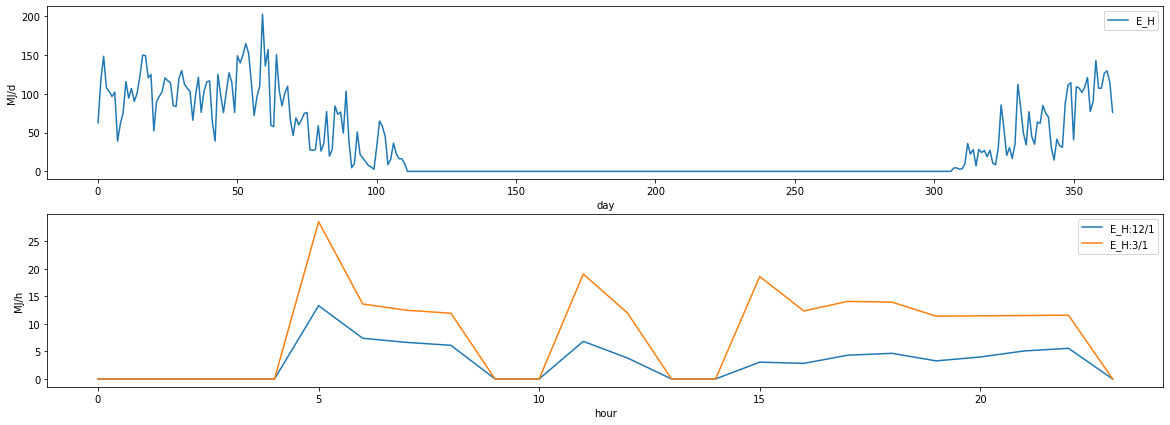

In [42]:
get_each_graph(_E_H_d_t_1)

### 計算条件2

- 敷設率を0.3、仮想床の床面積を除いた敷設率を0.4に変更

In [43]:
house_base, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_MR['r_Af'] = 0.3
H_MR['r_dash_Af'] = 0.4

_E_H_d_t_2 = calc_results(house_base, H_MR, H_OR, i)


E_H:12366.867949013025MJ/y


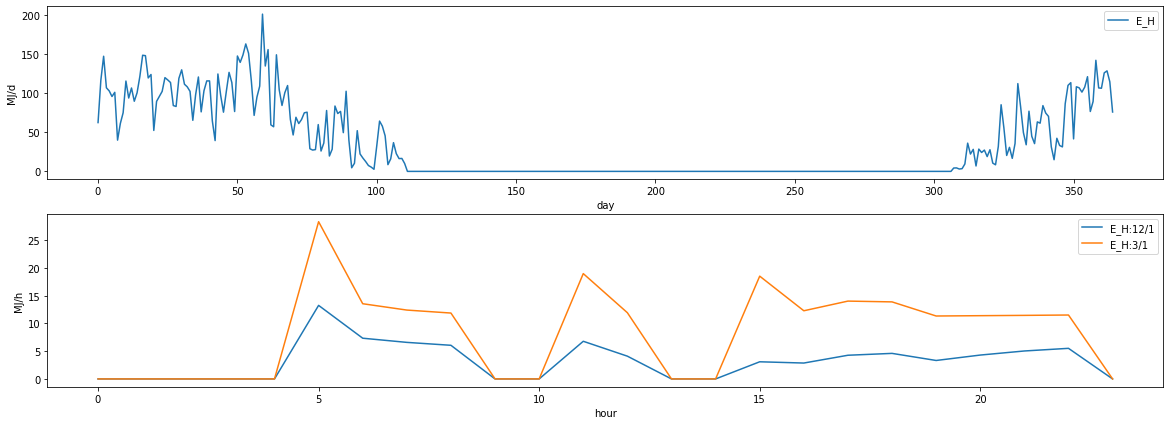

In [44]:
get_each_graph(_E_H_d_t_2)

### 計算条件3

- 上面放熱率（床の断熱）を0.95、配管断熱を評価しないに変更

In [45]:
house_base, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_MR['r_up'] = 0.95
H_MR['pipe_insulation'] = False

_E_H_d_t_3 = calc_results(house_base, H_MR, H_OR, i)

E_H:12361.117120496176MJ/y


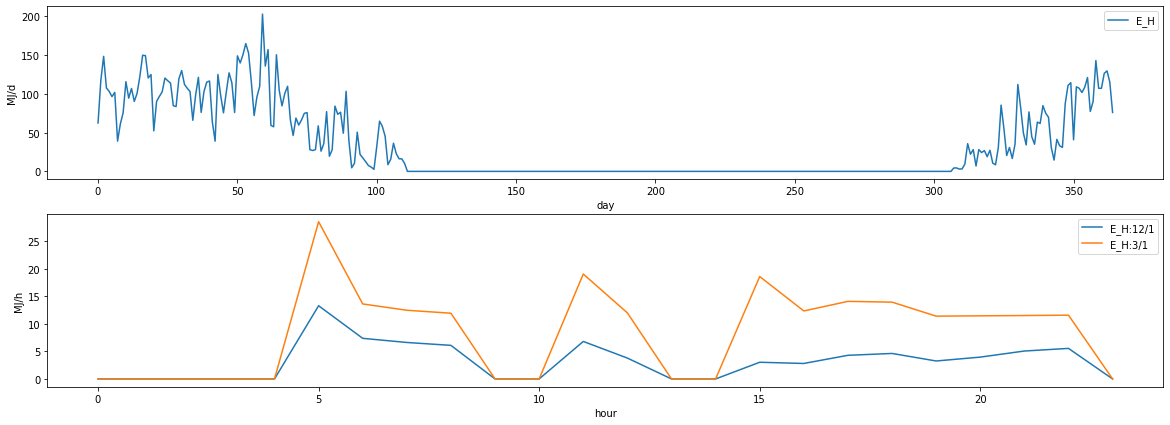

In [46]:
get_each_graph(_E_H_d_t_3)

### 計算条件4

- その他居室の暖房設備をルームエアコンディショナー付温水床暖房機、敷設率を0.3、上面放熱率（床の断熱）を0.90、配管断熱を採用するに変更
- 暖冷房区画を5に変更 

In [47]:
house_base, H_MR, H_OR, i = get_default_hot_water_floor_heating_with_rac()
H_OR = {'type': 'ルームエアコンディショナー付温水床暖房機', 'r_Af': 0.3, 'r_up': 0.90, 'pipe_insulation': True}
i = 5

_E_H_d_t_4 = calc_results(house_base, H_MR, H_OR, i)

E_H:2642.0944479095697MJ/y


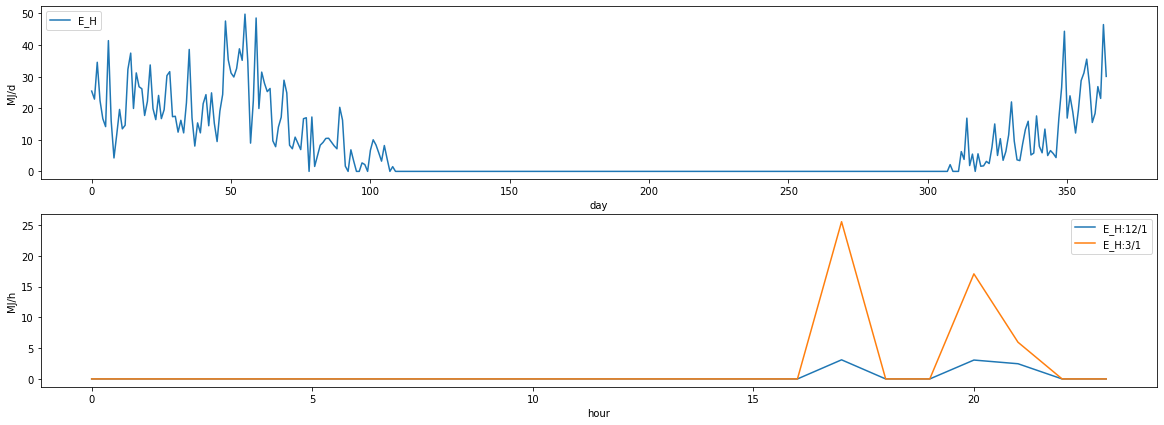

In [48]:
get_each_graph(_E_H_d_t_4)

### 比較

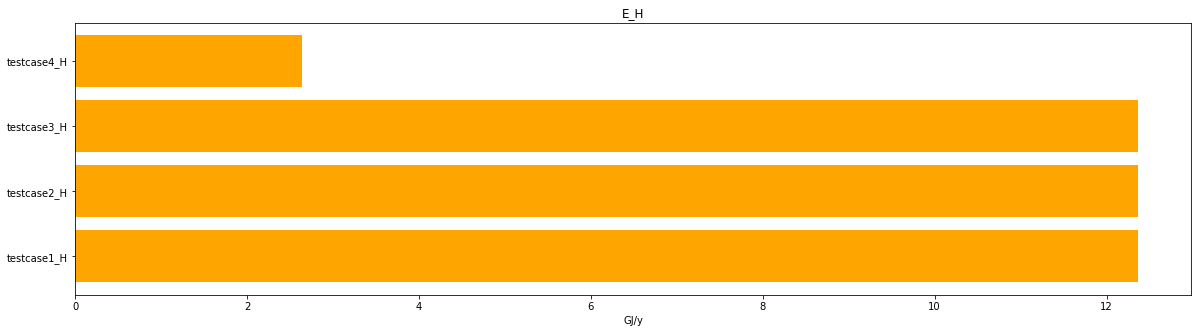

In [49]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()